# Integrating gene expression and chromatin accessibility of 10k PBMCs

This notebook demonstrates a basic application of `MuVI` on a single-cell RNA-seq dataset of peripheral blood mononuclear cells (PBMCs) from lupus patients [Kang et al., 2018](https://www.nature.com/articles/nbt.4042), where cells were either stimulated with Interferon-β or left untreated. 

In [1]:
import anndata as ad

In [2]:
import muvi

In [3]:
%matplotlib

%matplotlib inline
import seaborn as sns

Using matplotlib backend: <object object at 0x7f543b9bbba0>


In [4]:
# plotting settings
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [5]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)

We adopt the preprocessing from [Rybakov et al., 2020](https://doi.org/10.1101/2020.12.02.401182). First, we load the processed AnnData object from the `.h5ad` file:

In [6]:
adata = ad.read("../../../data/muvi/kang_pp.h5ad")
adata

/home/aqoku/miniconda3/envs/muvi_main/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 13576 × 979
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'
    uns: 'condition_colors', 'terms'
    varm: 'gene_set_mask'

## Informed Latent Decomposition

For this analysis we use the prior information from [Reactome](https://reactome.org/) which has already been stored inside `adata.varm['gene_set_mask']`.

In [7]:
model = muvi.tl.from_adata(
    adata,
    prior_mask_key="gene_set_mask",
    view_names=["rna"],
    prior_confidence="med",
    n_factors=1,
    device=device,
)
model

2024-06-21 16:38:37,120 - muvi.core.models - WARNING - Running MuVI on a single view.
2024-06-21 16:38:37,122 - muvi.core.models - INFO - pd.DataFrame detected.
2024-06-21 16:38:37,123 - muvi.core.models - INFO - Storing the index of the view `rna` as sample names.
2024-06-21 16:38:37,125 - muvi.core.models - INFO - pd.DataFrame detected.
2024-06-21 16:38:37,129 - muvi.core.models - INFO - pd.DataFrame detected.
2024-06-21 16:38:37,133 - muvi.core.models - INFO - Storing the index of the mask `rna` as factor names.
2024-06-21 16:38:37,136 - muvi.core.models - INFO - Likelihoods set to `{'rna': 'normal'}`.
2024-06-21 16:38:37,136 - muvi.core.models - INFO - NMF set to `{'rna': False}`.
2024-06-21 16:38:37,137 - muvi.core.models - INFO - Normalizing observations.
2024-06-21 16:38:37,137 - muvi.core.models - INFO - Centering features of view `rna`.
2024-06-21 16:38:37,281 - muvi.core.models - INFO - Setting global standard deviation to 1.0 (from 1.000).
2024-06-21 16:38:37,287 - muvi.core

|================================|
|       MuVI version 0.1.3       |
|================================|
| Parameter        | Value       |
|------------------|-------------|
| n_views          | 1           |
| n_samples        | 13576       |
| n_features       | rna: 979    |
| n_factors        | 135         |
| prior_confidence | 0.995       |
| n_covariates     | 0           |
| likelihoods      | rna: normal |
| nmf              | rna: False  |
| reg_hs           | True        |
| device           | cuda:1      |
|================================|

Train the model using stochastic variational inference (SVI) in order to utilize smaller batches of the whole dataset to avoid loading the whole dataset onto the GPU. The training takes around 6 minutes on a single Quadro RTX 5000 NVIDIA GPU.

In [8]:
model.fit(seed=0)

2024-06-21 16:38:37,302 - muvi.core.models - INFO - Preparing model and guide...
2024-06-21 16:38:37,412 - muvi.core.models - INFO - Preparing optimizer...
2024-06-21 16:38:37,413 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2024-06-21 16:38:37,414 - muvi.core.models - INFO - Preparing SVI...
2024-06-21 16:38:37,415 - muvi.core.models - INFO - Preparing training data...
2024-06-21 16:38:37,440 - muvi.core.models - INFO - Using complete dataset.
2024-06-21 16:38:37,457 - muvi.core.models - INFO - Setting training seed to `0`.
2024-06-21 16:38:37,466 - muvi.core.models - INFO - Cleaning parameter store.
2024-06-21 16:38:37,467 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2024-06-21 16:38:39,263 - root - INFO - Guessed max_plate_nesting = 2


 22%|██▏       | 2197/10000 [01:49<06:29, 20.06it/s, ELBO=626]   

Relative improvement of -0.0005157 < 1e-05 for 10 step(s) in a row, stopping early.
2024-06-21 16:40:27,009 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

In [9]:
# to speed up the process, use a random subsample to approximate the variance explained
r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
r2_view

2024-06-21 16:40:27,038 - muvi.tools.utils - INFO - Estimating `r2` with a random sample of 1000 samples.
2024-06-21 16:40:27,057 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/miniconda3/envs/muvi_main/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


{'rna': 0.6228673458099365}

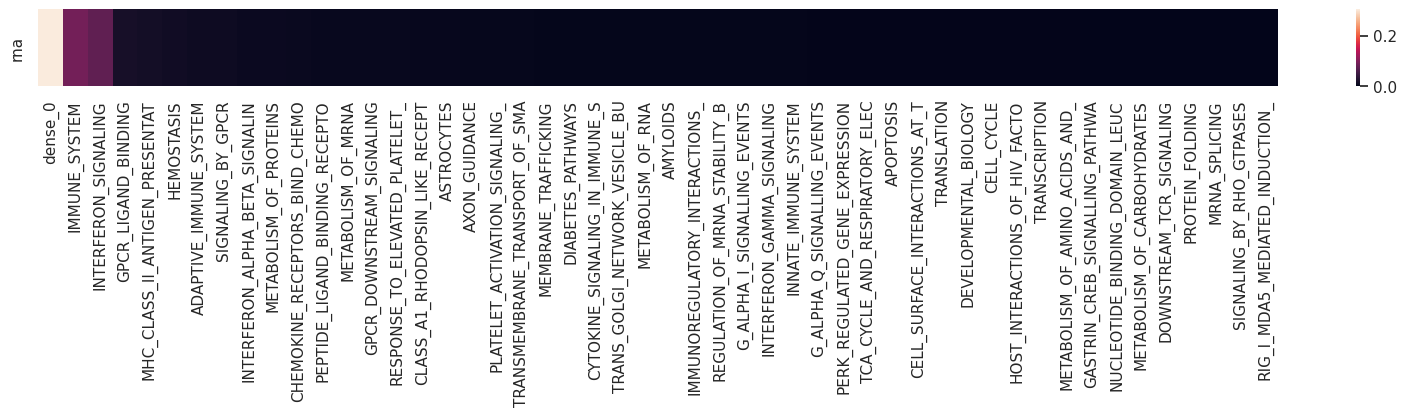

<Axes: >

In [10]:
muvi.pl.variance_explained(model)

Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing. 

Unless we provide other feature sets, e.g. [Gene Ontology](http://geneontology.org/), `muvi` automatically compares each inferred factor against its corresponding prior gene set annotation.

In [11]:
_ = muvi.tl.test(model)

2024-06-21 16:40:29,312 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.


100%|██████████| 134/134 [00:10<00:00, 12.73it/s]

2024-06-21 16:40:39,967 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.



100%|██████████| 134/134 [00:10<00:00, 12.69it/s]


Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

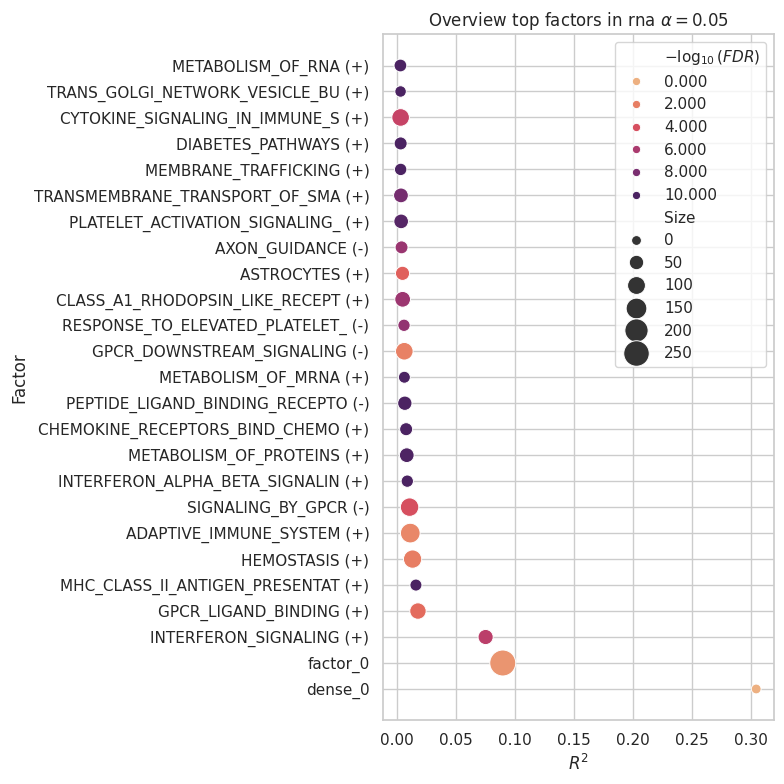

(<Figure size 800x800 with 1 Axes>,
 array([[<Axes: title={'center': 'Overview top factors in rna $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>]],
       dtype=object))

In [12]:
muvi.pl.factors_overview(model)

In [13]:
# add obs metadata
model._cache.factor_adata.obs = adata.obs.copy()

After copying the metadata stored in `adata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes.

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [14]:
muvi.tl.filter_factors(model)

2024-06-21 16:40:51,858 - muvi.tools.utils - INFO - Filtering down to 54 factors.
2024-06-21 16:40:51,868 - muvi.tools.cache - INFO - Factors filtered successfully.


True

Now we can proceed to perform clustering on top of the inferred and filtered latent space.

In [15]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

/home/aqoku/projects/code/MuVI/muvi/tools/utils.py:773: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return cluster_fn(setup_cache(model).factor_adata, **kwargs)


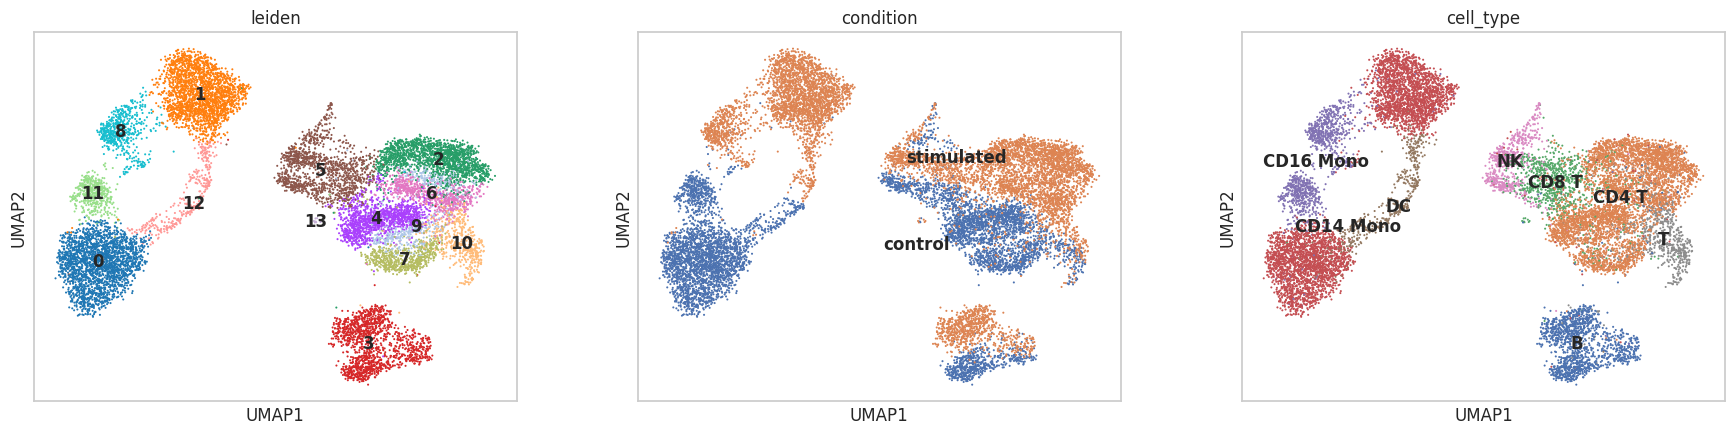

In [16]:
groupby = "leiden"
color = [groupby, "condition", "cell_type"]
muvi.pl.umap(model, color, legend_loc="on data")

The inferred latent space captures major axes of variation such as different cell types. Next, we look into specific factors (pathways) that explain variance between both conditions. 

In [17]:
muvi.tl.rank(model, "condition", method="wilcoxon")

/home/aqoku/miniconda3/envs/muvi_main/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/aqoku/miniconda3/envs/muvi_main/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


2024-06-21 16:41:46,611 - muvi.tools.plotting - WARNING - dendrogram data not found (using `dendrogram_condition` as key). Running `muvi.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `muvi.tl.dendrogram` independently.


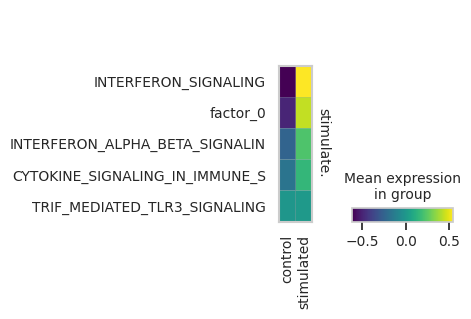

<Axes: >

In [18]:
muvi.pl.rank(
    model, n_factors=5, groups=["stimulated"], pl_type="matrixplot", swap_axes=True
)

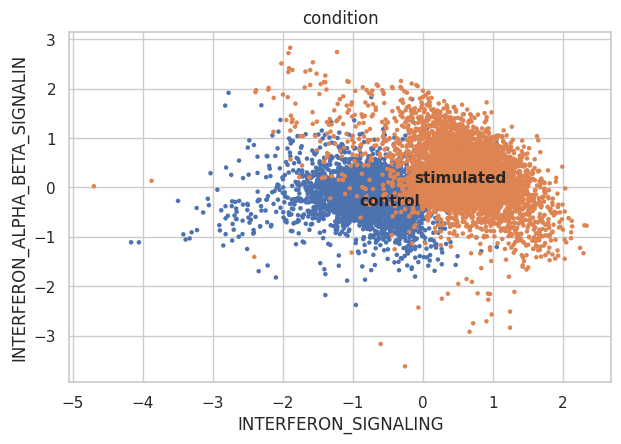

In [19]:
top_if_factors = ["INTERFERON_SIGNALING", "INTERFERON_ALPHA_BETA_SIGNALIN"]
muvi.pl.scatter(
    model,
    *top_if_factors,
    "condition",
    size=42,
    legend_loc="on data",
)

We may also explore the informed latent factors that are specific to particular cell types.

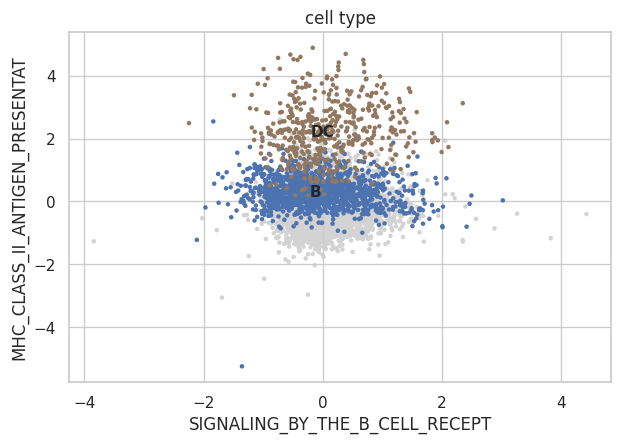

In [20]:
top_ct_factors = ["SIGNALING_BY_THE_B_CELL_RECEPT", "MHC_CLASS_II_ANTIGEN_PRESENTAT"]
muvi.pl.scatter(
    model,
    *top_ct_factors,
    "cell_type",
    groups=["B", "DC"],
    size=42,
    legend_loc="on data",
)

In [21]:
_ = muvi.tl.variance_explained_grouped(model, "cell_type")

/home/aqoku/projects/code/MuVI/muvi/tools/utils.py:412: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metadata.groupby(metadata)


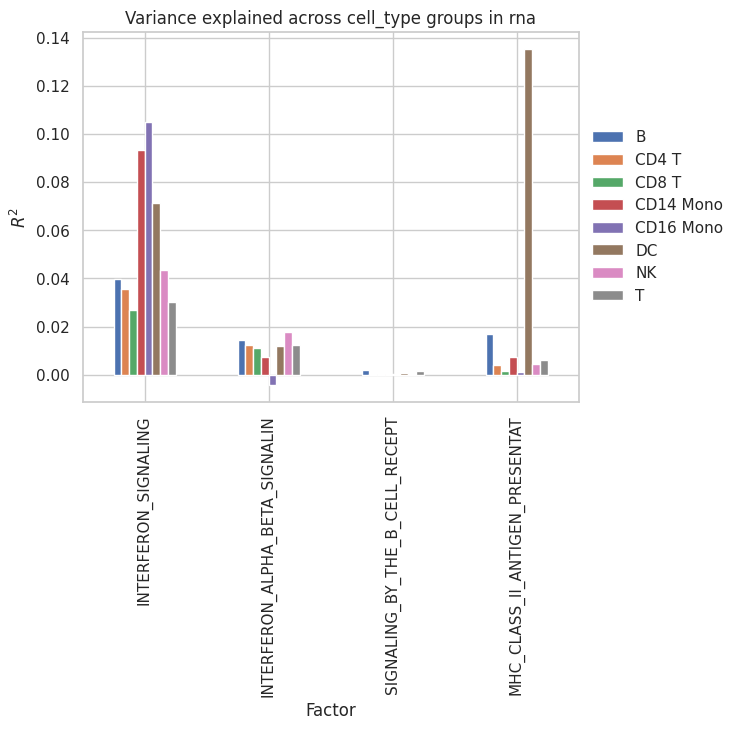

<Axes: title={'center': 'Variance explained across cell_type groups in rna'}, xlabel='Factor', ylabel='$R^2$'>

In [24]:
muvi.pl.variance_explained_grouped(
    model,
    top_if_factors + top_ct_factors,
    stacked=False,
)

To inspect a single factor in a single view regarding its factors loadings, simply call `muvi.pl.inspect_factor`. The features originating from the prior gene set annotation are shown as annotated (black), whereas the new features added during training are shown as inferred (red). As a result, we obtain a data-driven refinement of the prior feature sets.

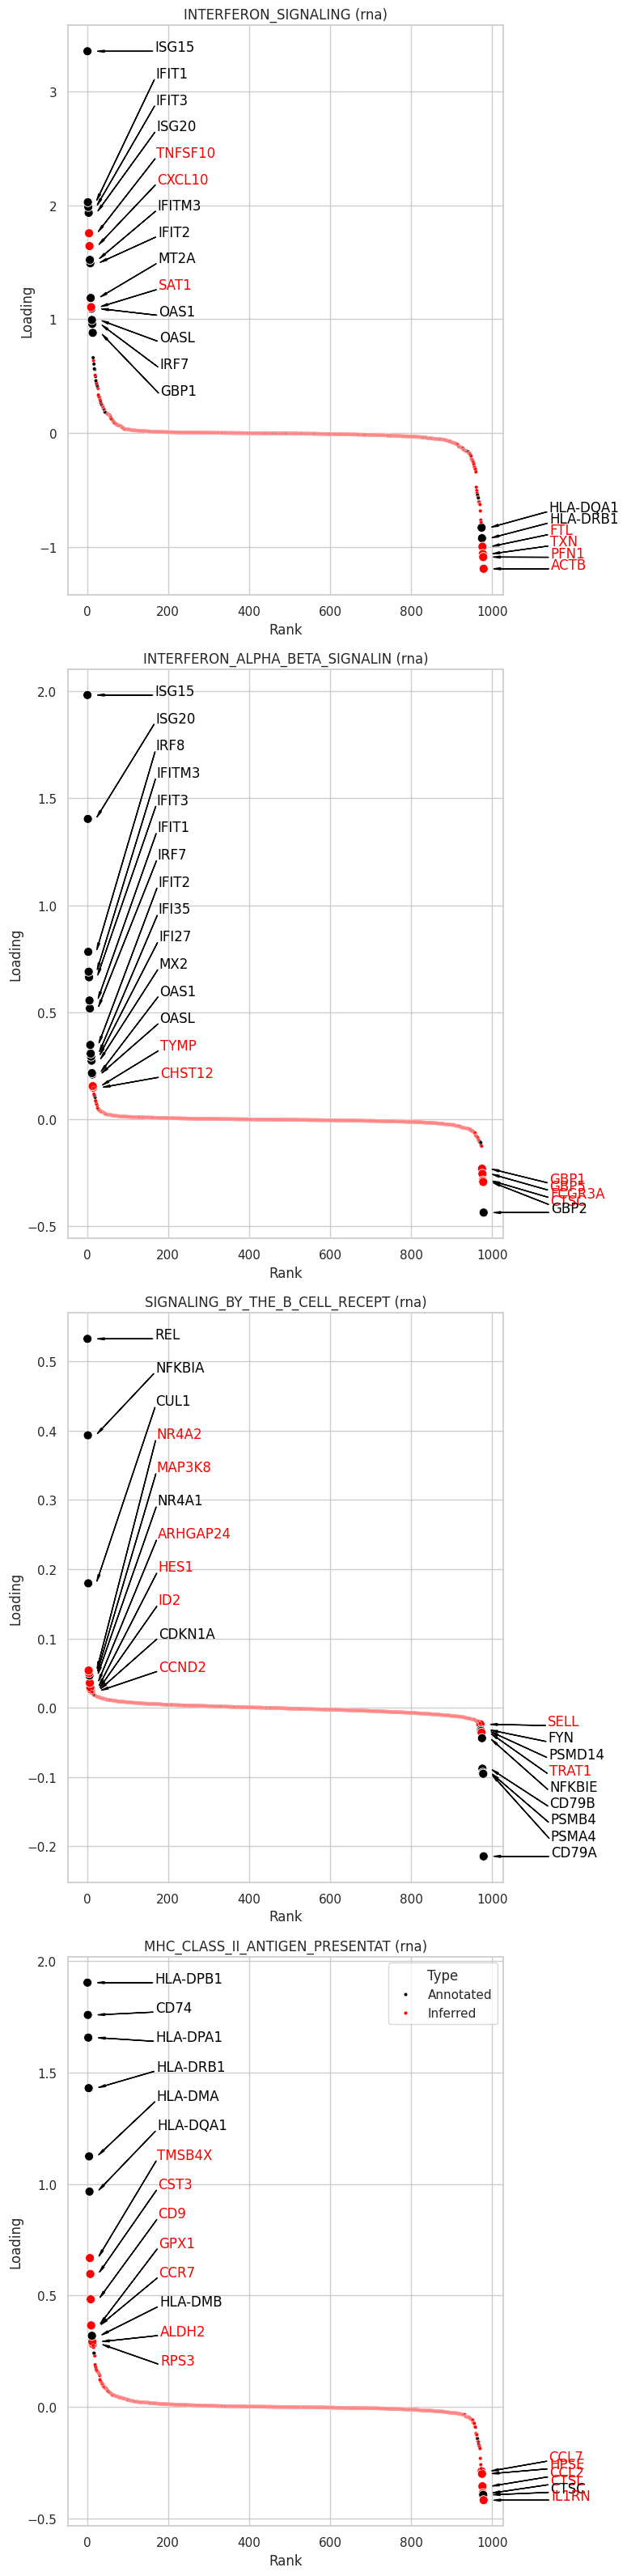

(<Figure size 800x3200 with 4 Axes>,
 array([[<Axes: title={'center': 'INTERFERON_SIGNALING (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'INTERFERON_ALPHA_BETA_SIGNALIN (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'SIGNALING_BY_THE_B_CELL_RECEPT (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'MHC_CLASS_II_ANTIGEN_PRESENTAT (rna)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

In [23]:
muvi.pl.inspect_factor(
    model,
    top_if_factors + top_ct_factors,
    top=20,
)

Head out to [this notebook](3a_single-cell_multi-omics_integration.ipynb) for an application of `MuVI` on a single-cell multiome dataset.